In [ ]:
# pip install pandas numpy scikit-learn matplotlib tensorflow

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau, ModelCheckpoint

In [2]:
# 1. Load the dataset
data = pd.read_csv('./data/BrentOilPricesMerged.csv')

In [3]:
# 2. Preprocess the data
# Convert Date to datetime format
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [4]:
data.head()

,Price,neg_oil,neu_oil,pos_oil,compound_oil,neg_war,neu_war,pos_war,compound_war
Date,,,,,,,,,
2023-04-03,84.930000,0.000,0.000,0.000,0.0000,0.000,0.000,0.000,0.0000
2023-04-04,84.940002,0.000,0.000,0.000,0.0000,0.000,0.000,0.000,0.0000
2023-04-05,84.989998,0.000,0.000,0.000,0.0000,0.000,0.000,0.000,0.0000
2023-04-06,85.120003,0.000,0.000,0.000,0.0000,0.000,0.776,0.224,0.9866
2023-04-10,84.180000,0.086,0.816,0.098,0.9796,0.144,0.708,0.147,-0.1356


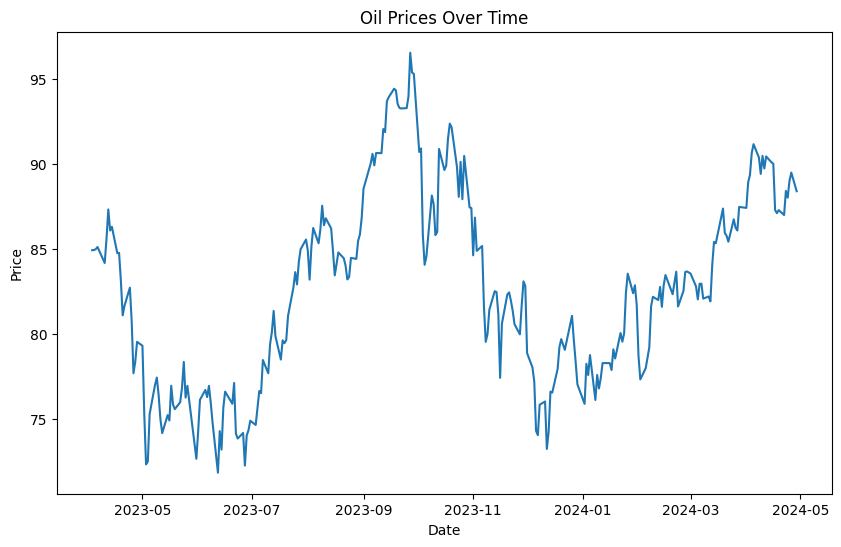

In [5]:
# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(data['Price'])
plt.title('Oil Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [4]:
# Extract the relevant columns for oil sentiment data
war_data = data[['Price', 'neg_war', 'neu_war', 'pos_war', 'compound_war']]
war_data.head()

,Price,neg_war,neu_war,pos_war,compound_war
Date,,,,,
2023-04-03,84.930000,0.000,0.000,0.000,0.0000
2023-04-04,84.940002,0.000,0.000,0.000,0.0000
2023-04-05,84.989998,0.000,0.000,0.000,0.0000
2023-04-06,85.120003,0.000,0.776,0.224,0.9866
2023-04-10,84.180000,0.144,0.708,0.147,-0.1356


In [5]:
# Normalize the price data
scaler = MinMaxScaler(feature_range=(0, 1))
# data['Price'] = scaler.fit_transform(data['Price'].values.reshape(-1, 1))
oil_data = scaler.fit_transform(war_data)

In [ ]:
# Extract the relevant columns for oil sentiment data
# oil_data = data[['Price', 'neg_oil', 'neu_oil', 'pos_oil', 'compound_oil']]

# # Scale the data
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_oil_data = scaler.fit_transform(oil_data)

In [6]:
# Create sequences of 60 time steps
def create_sequences_multivariate(data, time_steps=60):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps,0])  # Predict the 'Price' column
    return np.array(X), np.array(y)

In [55]:
# oil_data.iloc[0]['Price']

In [7]:
seq_length = 60
X, y = create_sequences_multivariate(oil_data, seq_length)
print(X.shape )
print(y.shape )


(211, 60, 5)
(211,)


In [8]:
# Split into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Split into train and test sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
Y_train, Y_test = y[:split], y[split:]
print(X_train.shape )
print(X_test.shape )


(168, 60, 5)
(43, 60, 5)


In [42]:
# Reshape X for LSTM [samples, time steps, features]
# X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
# X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [9]:
# 3. Build the LSTM model
model1 = Sequential()
model1.add(LSTM(50, return_sequences=True, input_shape=(seq_length, X_train.shape[2])))
model1.add(Dropout(0.2))
model1.add(LSTM(50, return_sequences=False))
model1.add(Dropout(0.2))
model1.add(Dense(1))

In [12]:
model1.compile(optimizer='adam', loss='mean_squared_error')

In [13]:
# 4. Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',patience=5)

history1 = model1.fit(
    X_train, 
    Y_train, 
    epochs=100, 
    batch_size=32, 
    validation_data=(X_test, Y_test), 
    callbacks=[early_stopping,reduce_lr]
)

Epoch 1/100
6/6 [==============================] - 5s 179ms/step - loss: 0.0965 - val_loss: 0.0179 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 0s 33ms/step - loss: 0.0485 - val_loss: 0.0342 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 0s 36ms/step - loss: 0.0355 - val_loss: 0.0235 - lr: 0.0010
Epoch 4/100
6/6 [==============================] - 0s 37ms/step - loss: 0.0213 - val_loss: 0.0059 - lr: 0.0010
Epoch 5/100
6/6 [==============================] - 0s 36ms/step - loss: 0.0177 - val_loss: 0.0092 - lr: 0.0010
Epoch 6/100
6/6 [==============================] - 0s 34ms/step - loss: 0.0172 - val_loss: 0.0101 - lr: 0.0010
Epoch 7/100
6/6 [==============================] - 0s 40ms/step - loss: 0.0154 - val_loss: 0.0055 - lr: 0.0010
Epoch 8/100
6/6 [==============================] - 0s 39ms/step - loss: 0.0137 - val_loss: 0.0130 - lr: 0.0010
Epoch 9/100
6/6 [==============================] - 0s 37ms/step - loss: 0.0129 - val_loss: 0.0057 - lr: 0.0010


In [14]:
# 5. Evaluate the model
train_predict = model1.predict(X_train)
test_predict = model1.predict(X_test)
train_predict[0]

2/2 [==============================] - 0s 6ms/step


array([0.2871031], dtype=float32)

In [15]:

# invert predictions
# train_predict = scaler.inverse_transform(train_predict)
train_predict = scaler.inverse_transform(np.concatenate((train_predict, np.zeros((train_predict.shape[0], X_train.shape[2] - 1))), axis=1))[:, 0]
# Y_train = scaler.inverse_transform(Y_train.reshape(-1, 1))
Y_train = scaler.inverse_transform(np.concatenate((Y_train.reshape(-1, 1), np.zeros((Y_train.shape[0], X_train.shape[2] - 1))), axis=1))[:, 0]

# test_predict = scaler.inverse_transform(test_predict)
test_predict = scaler.inverse_transform(np.concatenate((test_predict, np.zeros((test_predict.shape[0], X_test.shape[2] - 1))), axis=1))[:, 0]
# Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))
Y_test = scaler.inverse_transform(np.concatenate((Y_test.reshape(-1, 1), np.zeros((Y_test.shape[0], X_test.shape[2] - 1))), axis=1))[:, 0]

# y_pred = model1.predict(X_test)
# y_pred = scaler.inverse_transform(y_pred)
# y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [16]:
print('Model 01:')

print('Train Mean Absolute Error:', mean_absolute_error(Y_train, train_predict))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train, train_predict)))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test, test_predict)))

Model 01:
Train Mean Absolute Error: 1.9187928965441725
Train Root Mean Squared Error: 2.4732338466393404
Test Mean Absolute Error: 1.5478145700784345
Test Root Mean Squared Error: 1.8268855321071578


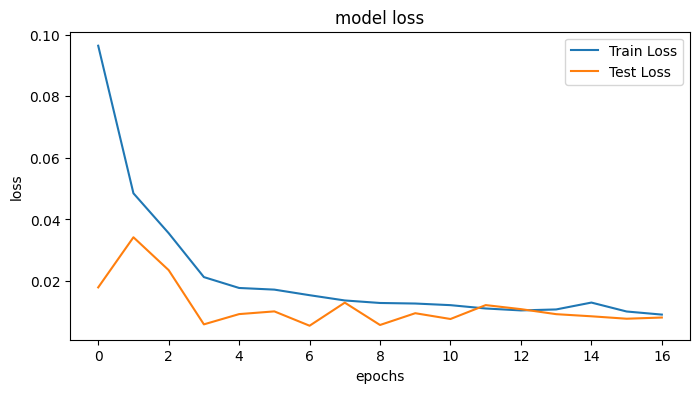

In [17]:
# Plot Train vs Test Loss
plt.figure(figsize=(8,4))
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.savefig('outputs/reddit war - lstm model 01 model loss.png')
plt.show()

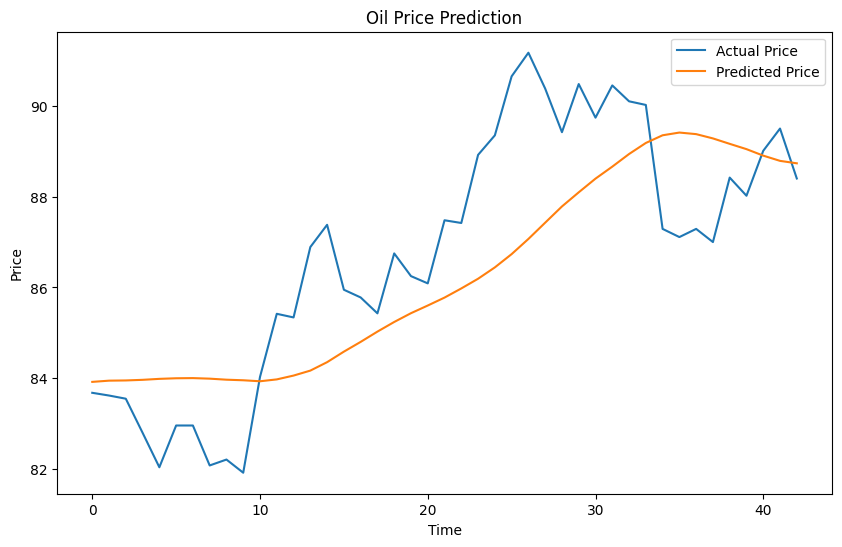

In [18]:
# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(Y_test, label='Actual Price')
plt.plot(test_predict, label='Predicted Price')
plt.title('Oil Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.savefig('outputs/reddit war - lstm model 01 Oil Price Prediction.png')
plt.show()

In [18]:
model1.save('models/reddit war - LSTM_01.h5') 

# returns a compiled model
# identical to the previous one
# model1 = load_model('my_model.h5')

C:\Users\theekshanas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### model 2

In [19]:
# Build the LSTM model
model2 = Sequential()
model2.add(LSTM(units=60, return_sequences=True, input_shape=(seq_length,  X_train.shape[2])))
model2.add(Dropout(0.1))
model2.add(LSTM(units=60, return_sequences=True))
model2.add(Dropout(0.1))
model2.add(LSTM(units=60, return_sequences=False))
model2.add(Dropout(0.1))
model2.add(Dense(units=1))

In [20]:
model2.compile(optimizer='adam', loss='mean_squared_error')

In [21]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',patience=5)

history2 = model2.fit(
    X_train, 
    Y_train, 
    epochs=100, 
    batch_size=32, 
    validation_data=(X_test, Y_test), 
    callbacks=[early_stopping,reduce_lr]
)

Epoch 1/100
6/6 [==============================] - 6s 247ms/step - loss: 6914.9033 - val_loss: 7282.6016 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 0s 50ms/step - loss: 6537.2739 - val_loss: 6748.7222 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 0s 50ms/step - loss: 6108.7388 - val_loss: 6425.2168 - lr: 0.0010
Epoch 4/100
6/6 [==============================] - 0s 49ms/step - loss: 5820.5649 - val_loss: 6154.2695 - lr: 0.0010
Epoch 5/100
6/6 [==============================] - 0s 59ms/step - loss: 5575.2993 - val_loss: 5940.7212 - lr: 0.0010
Epoch 6/100
6/6 [==============================] - 0s 50ms/step - loss: 5385.1104 - val_loss: 5785.7256 - lr: 0.0010
Epoch 7/100
6/6 [==============================] - 0s 51ms/step - loss: 5266.2773 - val_loss: 5676.8721 - lr: 0.0010
Epoch 8/100
6/6 [==============================] - 0s 50ms/step - loss: 5161.9556 - val_loss: 5591.9111 - lr: 0.0010
Epoch 9/100
6/6 [==============================] - 0s 52ms/step

In [22]:
# Evaluate the model
train_predict = model2.predict(X_train)
test_predict = model2.predict(X_test)

# invert predictions
train_predict = scaler.inverse_transform(np.concatenate((train_predict, np.zeros((train_predict.shape[0], X_train.shape[2] - 1))), axis=1))[:, 0]
Y_train = scaler.inverse_transform(np.concatenate((Y_train.reshape(-1, 1), np.zeros((Y_train.shape[0], X_train.shape[2] - 1))), axis=1))[:, 0]

test_predict = scaler.inverse_transform(np.concatenate((test_predict, np.zeros((test_predict.shape[0], X_test.shape[2] - 1))), axis=1))[:, 0]
Y_test = scaler.inverse_transform(np.concatenate((Y_test.reshape(-1, 1), np.zeros((Y_test.shape[0], X_test.shape[2] - 1))), axis=1))[:, 0]


2/2 [==============================] - 0s 9ms/step


In [23]:
print('Model 02:')

print('Train Mean Absolute Error:', mean_absolute_error(Y_train, train_predict))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train, train_predict)))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test, test_predict)))

Model 02:
Train Mean Absolute Error: 1002.1052482044992
Train Root Mean Squared Error: 1010.7182977609453
Test Mean Absolute Error: 1086.821361393322
Test Root Mean Squared Error: 1088.9347843384435


#### by observing results with model 01 and model 02, model 01 seems to perform better

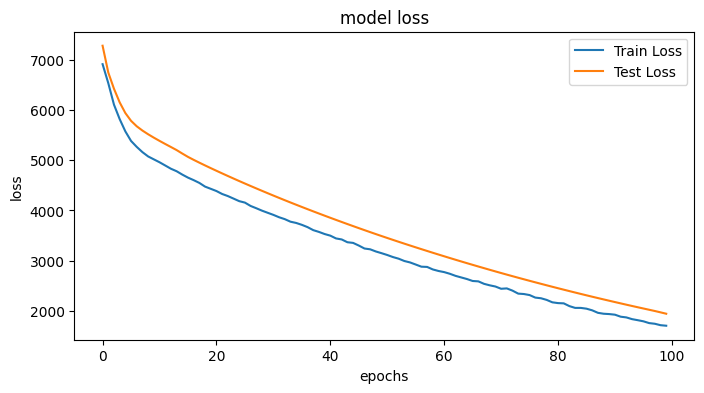

In [24]:
# Plot Train vs Test Loss
plt.figure(figsize=(8,4))
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.savefig('outputs/reddit war - lstm model 02 model loss.png')
plt.show()

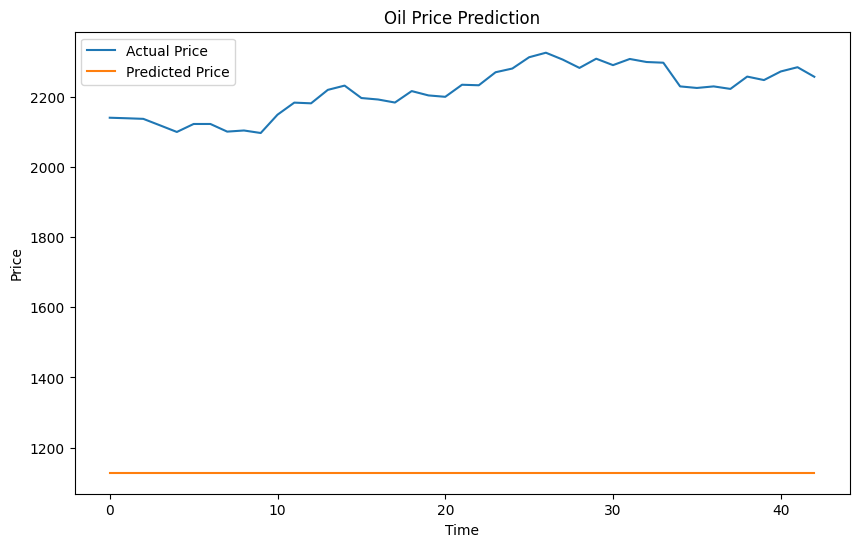

In [25]:
# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(Y_test, label='Actual Price')
plt.plot(test_predict, label='Predicted Price')
plt.title('Oil Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.savefig('outputs/reddit war - lstm model 02 Oil Price Prediction.png')
plt.show()

In [26]:
model2.save('models/reddit war - LSTM_02.h5') 

# returns a compiled model
# identical to the previous one
# model2 = load_model('my_model.h5')

C:\Users\theekshanas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [10]:
# Build the LSTM model
model3 = Sequential()
model3.add(LSTM(units=60, return_sequences=True, input_shape=(seq_length,  X_train.shape[2])))
model3.add(Dropout(0.2))
model3.add(LSTM(units=50, return_sequences=True))
model3.add(Dropout(0.2))
model3.add(LSTM(units=40, return_sequences=True))
model3.add(Dropout(0.2))
model3.add(LSTM(units=30, return_sequences=True))
model3.add(Dropout(0.2))
model3.add(LSTM(units=20, return_sequences=False))
model3.add(Dropout(0.2))
model3.add(Dense(units=1))

In [11]:
model3.compile(optimizer='adam', loss='mean_squared_error')

In [12]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',patience=5)

history3 = model3.fit(
    X_train, 
    Y_train, 
    epochs=100, 
    batch_size=32, 
    validation_data=(X_test, Y_test), 
    callbacks=[early_stopping,reduce_lr]
)

Epoch 1/100
6/6 [==============================] - 11s 497ms/step - loss: 0.1067 - val_loss: 0.0117 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 0s 80ms/step - loss: 0.0549 - val_loss: 0.0547 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 0s 79ms/step - loss: 0.0428 - val_loss: 0.0135 - lr: 0.0010
Epoch 4/100
6/6 [==============================] - 0s 78ms/step - loss: 0.0341 - val_loss: 0.0378 - lr: 0.0010
Epoch 5/100
6/6 [==============================] - 1s 88ms/step - loss: 0.0276 - val_loss: 0.0071 - lr: 0.0010
Epoch 6/100
6/6 [==============================] - 0s 80ms/step - loss: 0.0259 - val_loss: 0.0361 - lr: 0.0010
Epoch 7/100
6/6 [==============================] - 0s 84ms/step - loss: 0.0245 - val_loss: 0.0084 - lr: 0.0010
Epoch 8/100
6/6 [==============================] - 0s 79ms/step - loss: 0.0229 - val_loss: 0.0283 - lr: 0.0010
Epoch 9/100
6/6 [==============================] - 0s 77ms/step - loss: 0.0262 - val_loss: 0.0095 - lr: 0.0010

In [13]:
# Evaluate the model
train_predict = model3.predict(X_train)
test_predict = model3.predict(X_test)

# invert predictions
train_predict = scaler.inverse_transform(np.concatenate((train_predict, np.zeros((train_predict.shape[0], X_train.shape[2] - 1))), axis=1))[:, 0]
Y_train = scaler.inverse_transform(np.concatenate((Y_train.reshape(-1, 1), np.zeros((Y_train.shape[0], X_train.shape[2] - 1))), axis=1))[:, 0]

test_predict = scaler.inverse_transform(np.concatenate((test_predict, np.zeros((test_predict.shape[0], X_test.shape[2] - 1))), axis=1))[:, 0]
Y_test = scaler.inverse_transform(np.concatenate((Y_test.reshape(-1, 1), np.zeros((Y_test.shape[0], X_test.shape[2] - 1))), axis=1))[:, 0]


2/2 [==============================] - 0s 13ms/step


In [14]:
print('Model 03:')

print('Train Mean Absolute Error:', mean_absolute_error(Y_train, train_predict))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train, train_predict)))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test, test_predict)))

Model 03:
Train Mean Absolute Error: 2.913367327656537
Train Root Mean Squared Error: 3.717192409380901
Test Mean Absolute Error: 1.7146892248215306
Test Root Mean Squared Error: 2.0854195941329317


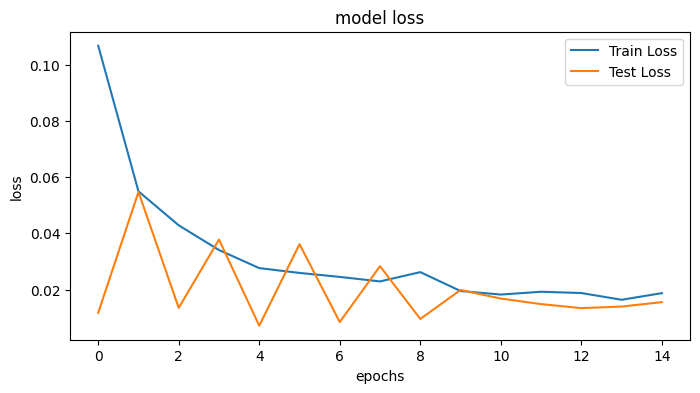

In [15]:
# Plot Train vs Test Loss
plt.figure(figsize=(8,4))
plt.plot(history3.history['loss'], label='Train Loss')
plt.plot(history3.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.savefig('outputs/reddit war - lstm model 03 model loss.png')
plt.show()

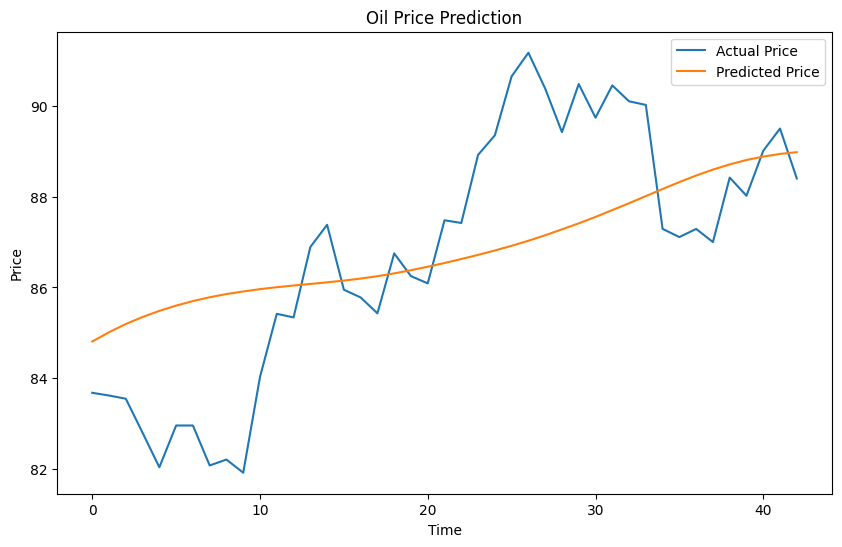

In [16]:
# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(Y_test, label='Actual Price')
plt.plot(test_predict, label='Predicted Price')
plt.title('Oil Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.savefig('outputs/reddit war - lstm model 03 Oil Price Prediction.png')
plt.show()

In [17]:
model3.save('models/reddit war - LSTM_03.h5') 

C:\Users\theekshanas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
